<a href="https://colab.research.google.com/github/ceyhunsahin/PYTORCH_WORKING/blob/master/Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2a974f11ca4756544826a9fe66adb1486171c25dd353390977d3d185117f1c77
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=f27112ac9c17b328f57323cde339884123e54f7f49055912f5b048fd88d5be1c
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 12.23 MiB/s, done.


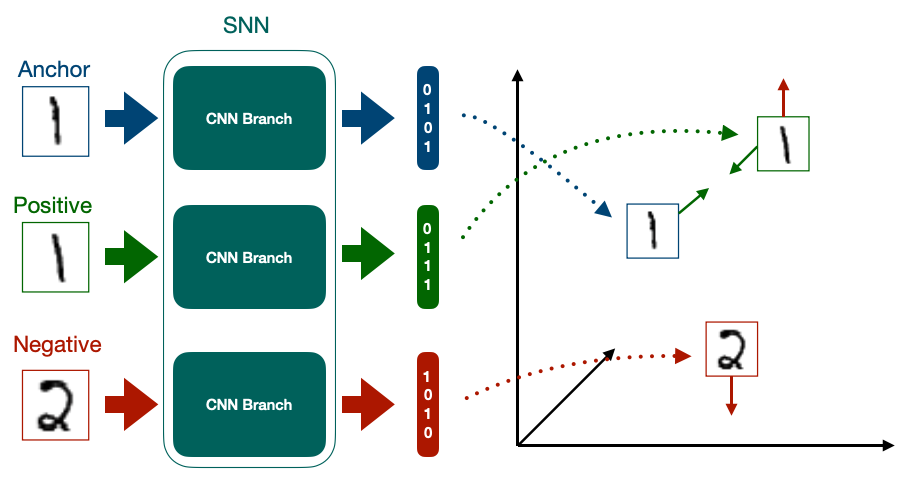

# Imports

In [3]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [5]:
DATA_DIR = 'Person-Re-Id-Dataset/train/'
CSV_FILE = 'Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

device = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[114]
A_img = io.imread(DATA_DIR + row.Anchor)
N_img = io.imread(DATA_DIR + row.Negative)
P_img = io.imread(DATA_DIR + row.Positive)


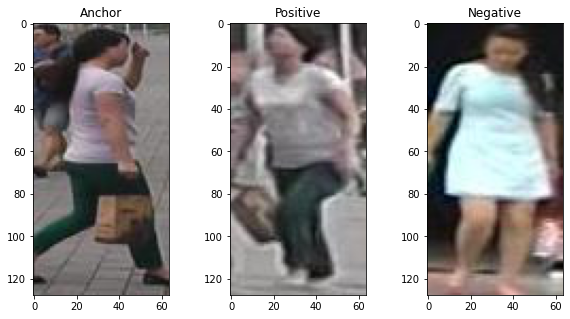

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
 B_img = torch.from_numpy(P_img).permute(2,0,1)
 B_img.shape

torch.Size([3, 128, 64])

# Create APN Dataset 

In [11]:
class APN_Dataset(Dataset):

  def __init__(self, df) :
    self.df = df

  def __len__(self) :
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    N_img = io.imread(DATA_DIR + row.Negative)
    P_img = io.imread(DATA_DIR + row.Positive)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0


    return A_img, P_img, N_img




In [12]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

size of trainset: 3200
size of validset: 800


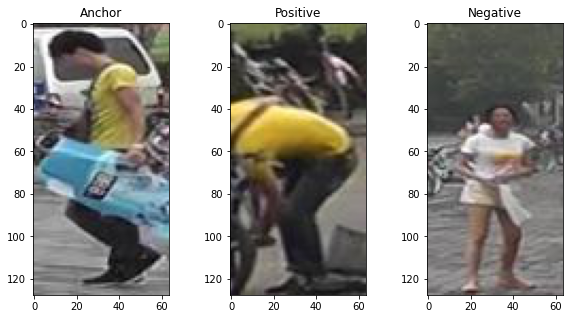

In [13]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
A,P,N = next(iter(trainloader))
    
print(f"One image batch shape : {P.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [17]:
from torchvision.models import efficientnet_b0
a = efficientnet_b0()
a

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
class APN_Model(nn.Module):
  def __init__(self, emb_size = 512) :
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  
  def forward(self, images) :
    embeddings = self.efficientnet(images)
    return embeddings


In [23]:
model = APN_Model()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [19]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(device),P.to(device),N.to(device)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    total_loss +=loss.item()

  return total_loss / len(dataloader)


In [20]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad() :

    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(device),P.to(device),N.to(device)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss +=loss.item()

    return total_loss / len(dataloader)

In [24]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [25]:
best_valid_loss = np.Inf

for i in range(EPOCHS) :
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss :
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED WEIGHTS SUCCESS')

  print(f"EPOCHS : {i+1} train_loss : {train_loss}")

100%|██████████| 25/25 [00:03<00:00,  8.21it/s]


SAVED WEIGHTS SUCCESS
EPOCHS : 1 train_loss : 0.6640504044294357


100%|██████████| 25/25 [00:03<00:00,  8.30it/s]


SAVED WEIGHTS SUCCESS
EPOCHS : 2 train_loss : 0.31030318766832354


100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


SAVED WEIGHTS SUCCESS
EPOCHS : 3 train_loss : 0.20299213245511055


100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


EPOCHS : 4 train_loss : 0.10395946100354195


100%|██████████| 25/25 [00:03<00:00,  8.04it/s]


SAVED WEIGHTS SUCCESS
EPOCHS : 5 train_loss : 0.09116212867200374


100%|██████████| 25/25 [00:04<00:00,  5.88it/s]


SAVED WEIGHTS SUCCESS
EPOCHS : 6 train_loss : 0.06553766503930092


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


EPOCHS : 7 train_loss : 0.05299049496650696


100%|██████████| 25/25 [00:05<00:00,  4.68it/s]


EPOCHS : 8 train_loss : 0.057947962954640386


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


EPOCHS : 9 train_loss : 0.06540965080261231


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


EPOCHS : 10 train_loss : 0.06814299777150154


100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


SAVED WEIGHTS SUCCESS
EPOCHS : 11 train_loss : 0.04847174838185311


100%|██████████| 25/25 [00:03<00:00,  8.20it/s]


EPOCHS : 12 train_loss : 0.03383914232254028


100%|██████████| 25/25 [00:03<00:00,  7.96it/s]


EPOCHS : 13 train_loss : 0.04422871604561806


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


EPOCHS : 14 train_loss : 0.03751327991485596


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]

EPOCHS : 15 train_loss : 0.03750291585922241


# Get Anchor Embeddings

In [26]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad() :
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(device)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc


In [27]:
model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [28]:
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:06<00:00, 59.78it/s]


In [29]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.979454,-0.610001,0.413193,-0.085028,0.092840,0.308026,0.082847,0.423442,-1.035164,...,-0.592919,0.259495,-0.199284,-0.367403,-1.009977,0.894473,-0.866711,0.767894,0.017105,-0.493470
1,1420_c3s3_061978_03.jpg,-1.154776,-0.974383,0.310414,-0.288462,-0.503272,-0.317059,0.077508,0.538613,-1.092342,...,-0.921363,-0.626380,0.043152,-0.482506,-0.758626,0.248397,-0.773951,0.898320,-0.424688,-0.508082
2,1420_c5s3_062565_05.jpg,-1.418946,-0.861489,0.436080,-0.499396,-0.295494,0.035498,0.060379,0.389590,-1.420216,...,-0.885923,-0.219830,-0.303693,-0.606341,-0.993239,0.686407,-1.007936,1.088532,-0.306093,-0.726985
3,1420_c6s3_085592_04.jpg,-0.542699,-0.792875,0.442402,-0.065960,0.128476,0.661099,0.249477,0.216021,-1.520579,...,-0.793054,-0.434862,-0.840386,-0.430097,-1.076013,0.825788,-0.932673,0.671807,-0.457215,-0.695753
4,0663_c5s3_085987_03.jpg,0.623889,0.859476,1.308960,0.735058,1.333646,1.459875,-0.084158,0.602276,-0.715134,...,-0.393857,1.282472,-0.226144,1.270959,-0.164924,0.769352,0.186721,-0.227780,-0.118717,-0.780925


# Inference

In [30]:
def euclidian_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist 

In [46]:
idx = 23
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.

model.eval()

with torch.no_grad():
  img = img.to(device)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()


In [47]:
anc_enc_arr = df_enc.iloc[:, 1:]
anc_img_names = df_enc['Anchor'] 

In [48]:
anc_enc_arr.iloc[0:1, :]

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.979454,-0.610001,0.413193,-0.085028,0.09284,0.308026,0.082847,0.423442,-1.035164,0.247421,...,-0.592919,0.259495,-0.199284,-0.367403,-1.009977,0.894473,-0.866711,0.767894,0.017105,-0.49347


In [49]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidian_dist(img_enc, anc_enc_arr.iloc[i : i + 1, :])
  distance = np.append(distance, dist)


In [50]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.8/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


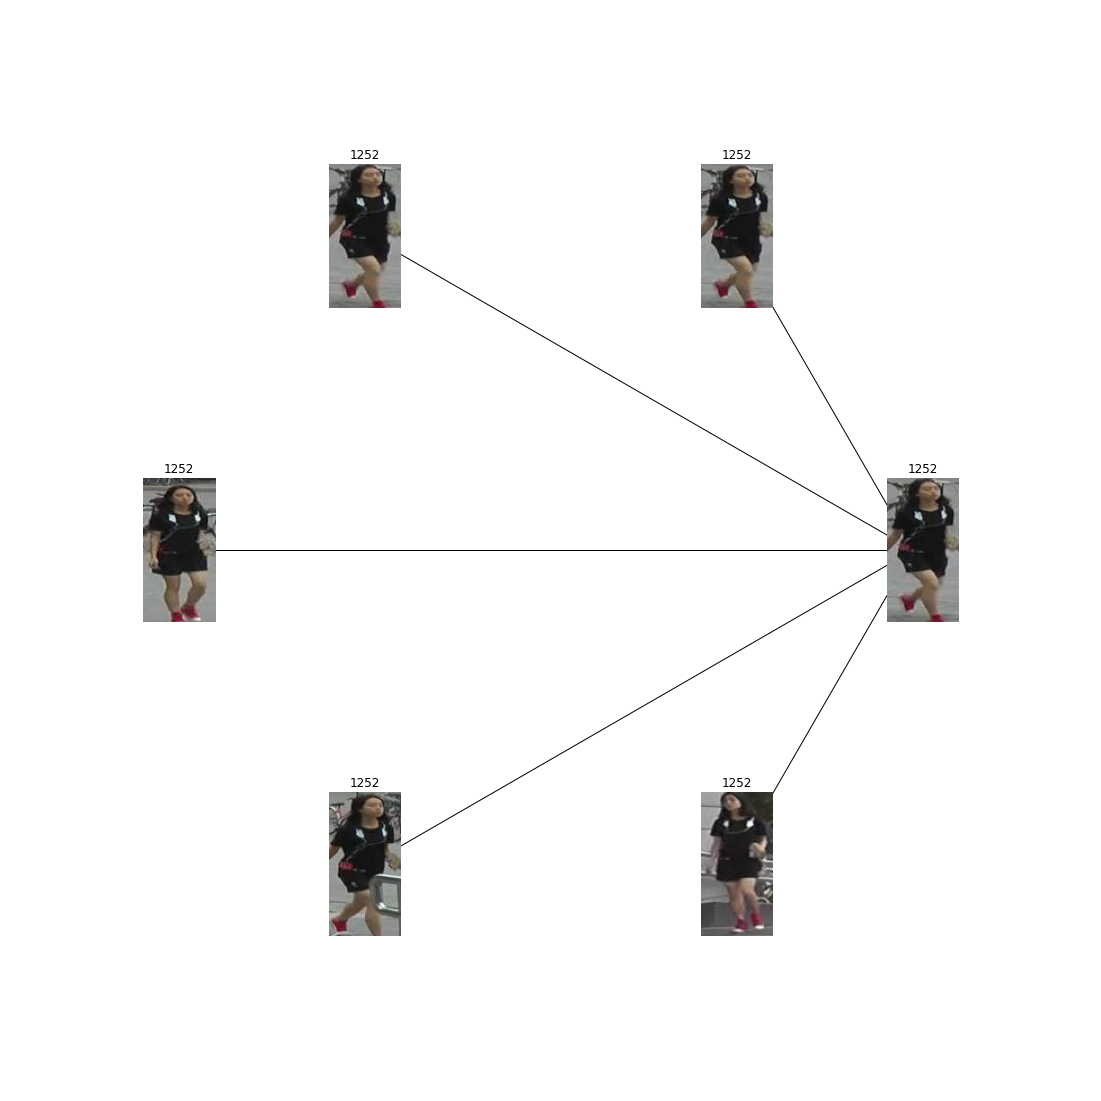

In [51]:
closest_idx = np.argsort(distance)